# Cookie Cats A/B‑Test

This document presents a consolidated and detailed analysis of the A/B test conducted for the mobile puzzle game, Cookie Cats. Our main objective is to understand how moving the first in-game gate from level 30 to level 40 impacts how long players continue to play the game (player retention).

## ***Table of Contents***
- **Problem Statement**: Why are we doing this test?
- **Data Loading and Initial Exploration**: Getting to know our data
- **Data Cleaning and Pre-processing**: Preparing the data for analysis
- **Exploratory Data Analysis (EDA)**: Visualizing and understanding the data
- **A/B Test Analysis**: Is the difference real?
  - **Retention Rate Calculation**: How many players stay?
  - **Bootstrapping for Retention Difference**: Simulating outcomes for confidence
  - **Statistical Significance Testing**: Confirming our observations
  - **Bayesian A/B Testing**: What is the probability one variant is better?
  - **Power Analysis and Sample Size Calculation**: How many players do we need?
- **Conclusion and Recommendations**: What should we do?

In [ ]:
# pip install -r requirements.txt

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import zt_ind_solve_power

## 1. ***Problem Statement: Why are we doing this test?***
Cookie Cats is a highly popular mobile puzzle game, a "connect three" style game where players clear boards by connecting same-colored tiles. As players advance through the game levels, they periodically encounter "gates." These gates act as checkpoints that require players to either wait a certain amount of time or make an in-app purchase to proceed to the next set of levels.

Why are these gates important? Beyond encouraging purchases, these gates serve a crucial purpose: they provide players with an enforced break from playing. This break is intended to increase and prolong the player's enjoyment of the game. Think of it like taking a break from eating your favorite dessert – it helps you appreciate it more when you come back to it.

The Business Question: The game developers are considering whether changing the position of the very first gate affects how long players stay engaged with the game. Initially, this first gate was placed at Level 30. In this A/B test, a new version of the game was created where the first gate was moved to Level 40.

Our goal is to analyze the results of this test to answer: Does moving the first gate from Level 30 to Level 40 have a positive, negative, or no significant impact on player retention (how many players return to play after 1 day and 7 days)? This insight will help the developers make an informed decision about the optimal gate placement.

## 2. ***Data Loading and Initial Exploration: Getting to know our data***
Before we can analyze anything, we need to load our data into a format that our tools can understand. Then, we'll take a first look at the data to get a general understanding of what information it contains and how it's structured. This initial exploration helps us spot any immediate issues or interesting patterns.

In [4]:
csv_path = 'dataset/cookie_cats.csv'
df = pd.read_csv(csv_path)

Display the first few rows of our DataFrame. This gives us a quick peek at the kind of data we have.

In [5]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### ***2.1 Structure, Duplicates and Missing Values***

Get a concise summary of the DataFrame.  
This tells us about the number of entries, the names of columns, what type of data is in each column (e.g., numbers, text, true/false), and if there are any missing values.

In [6]:

df.info()
print("\nMissing values per column:")
print(df.isna().sum())
dupes = df.duplicated('userid').sum()
print(f"Duplicate userids: {dupes}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB

Missing values per column:
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64
Duplicate userids: 0


Dataset columns:

| column | description |
|--------|-------------|
| `userid` | unique player ID |
| `version` | `'gate_30'` (control) or `'gate_40'` (treatment) |
| `sum_gamerounds` | total rounds played on first day |
| `retention_1` | 1‑day retention flag |
| `retention_7` | 7‑day retention flag |

---

### ***2.2 Descriptive Statistics***

Get descriptive statistics for numerical columns.  
This provides summary measures like the average, median, minimum, maximum, and how spread out the data is (standard deviation).

In [7]:
df.describe(include='all')

,userid,version,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189,90189.000000,90189,90189
unique,NaN,2,NaN,2,2
top,NaN,gate_40,NaN,False,False
freq,NaN,45489,NaN,50036,73408
mean,4.998412e+06,NaN,51.872457,NaN,NaN
std,2.883286e+06,NaN,195.050858,NaN,NaN
min,1.160000e+02,NaN,0.000000,NaN,NaN
25%,2.512230e+06,NaN,5.000000,NaN,NaN
50%,4.995815e+06,NaN,16.000000,NaN,NaN
75%,7.496452e+06,NaN,51.000000,NaN,NaN


### ***2.3 Unique Values***

Check for unique values in the `version` column and count them. This confirms how many players are in each version of the game (gate_30 vs. gate_40).  
Then check for unique values in `retention_1` and `retention_7` and count them. This shows how many players returned (True) and how many did not (False) after 1 day and 7 days.

In [8]:
print("\nUnique values in 'version' column:")
print(df['version'].value_counts())


Unique values in 'version' column:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


In [9]:
print("\nUnique values in 'retention_1':")
print(df['retention_1'].value_counts())
print("\nUnique values in 'retention_7':")
print(df['retention_7'].value_counts())


Unique values in 'retention_1':
retention_1
False    50036
True     40153
Name: count, dtype: int64

Unique values in 'retention_7':
retention_7
False    73408
True     16781
Name: count, dtype: int64


From this initial look, we see that our dataset contains 90,189 records (rows) with information about each player.  
There are no missing values, which is great, it means our data is complete.  
We have an almost equal number of players in the gate_40 group (45,489) and the gate_30 group (44,700), which is important for a fair A/B test.  
We also see the counts of players who retained (returned) after 1 day and 7 days.

One thing that stands out from the describe() output is the max value for sum_gamerounds: 49,854. This seems extremely high for game rounds played in a week and might be an unusual data point, or an "outlier," that could skew our results if not addressed.

## ***3. Data Cleaning and Pre-processing: Preparing the data for analysis***
Data cleaning is a crucial step to ensure the accuracy of our analysis. If our data contains errors or extreme values, our conclusions might be misleading.  
In this case, that sum_gamerounds value of 49,854 is highly suspicious. A single player playing nearly 50,000 rounds in a short period is unrealistic and is very likely an outlier. Such an outlier can heavily distort averages and other statistical measures, making it harder to see the true patterns in the rest of the data.  

Let's have a look at the boxplot distribution.

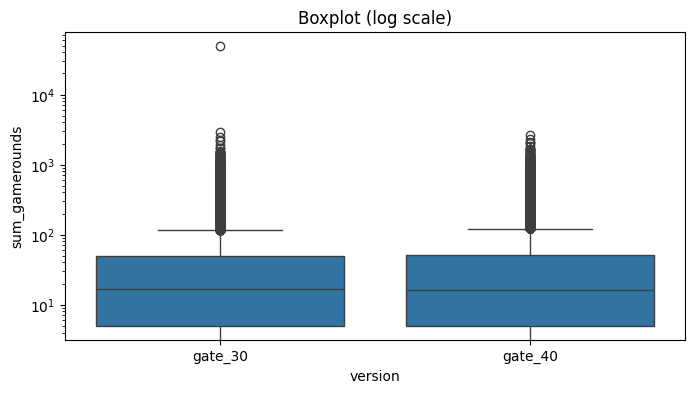

In [12]:
plt.figure(figsize=(8,4))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.yscale('log')
plt.title('Boxplot (log scale)')
plt.show()


There is a single value far away from all the others, we can evaluate the IQR and the values out of the interval.

In [13]:
q1, q3 = df['sum_gamerounds'].quantile([0.25,0.75])
iqr = q3 - q1
upper = q3 + 1.5*iqr
outliers = (df['sum_gamerounds'] > upper).sum()
print(f"Upper fence: {upper:.0f}. Outliers above fence: {outliers} ({outliers/len(df):.2%})")

Upper fence: 120. Outliers above fence: 10177 (11.28%)


Over 10% is a relevant number of records, we can assume they are not spare outliers, so we will simply remove the single value that is far from all the others.

In [14]:
df_cleaned = df[df['sum_gamerounds'] < df['sum_gamerounds'].max()]


To confirm that the outlier has been successfully removed, we'll display the descriptive statistics for 'sum_gamerounds' again.  
We expect the 'max' value to be significantly lower now.

In [15]:
print("Descriptive Statistics after outlier removal:")
print(df_cleaned.describe())

Descriptive Statistics after outlier removal:
             userid  sum_gamerounds
count  9.018800e+04    90188.000000
mean   4.998397e+06       51.320253
std    2.883298e+06      102.682719
min    1.160000e+02        0.000000
25%    2.512211e+06        5.000000
50%    4.995804e+06       16.000000
75%    7.496461e+06       51.000000
max    9.999861e+06     2961.000000


After removing the outlier, the max value for sum_gamerounds is now 2,961, which is much more realistic and reasonable. Our dataset now has 90,188 entries, one less than before, confirming the outlier's removal. This cleaned dataset will provide a more accurate basis for our analysis.

## ***4. Exploratory Data Analysis: Visualizing and understanding the data***
Instead of just looking at numbers, we create charts and graphs to understand the patterns, distributions, and relationships within our data. This helps us confirm our initial thoughts and uncover new insights.

One critical check in an A/B test is to ensure that the two groups (gate_30 and gate_40) were truly similar before the A/B test change was introduced. If they started out differently, any observed changes might not be due to the gate placement. We'll examine the distribution of sum_gamerounds (total game rounds played by a player) for both groups as an "invariant metric." This metric should ideally be similar between groups if the randomization was successful.

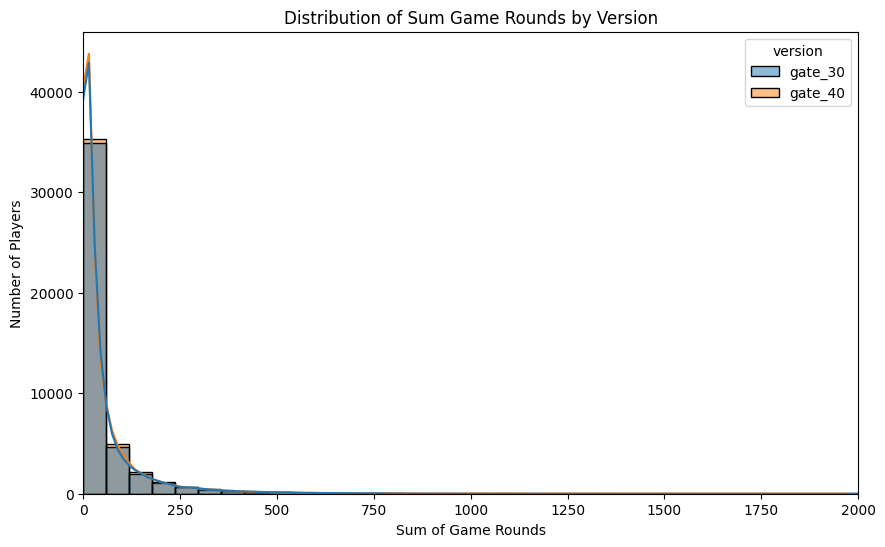

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='sum_gamerounds', hue='version', bins=50, kde=True)
plt.title('Distribution of Sum Game Rounds by Version') 
plt.xlabel('Sum of Game Rounds') 
plt.ylabel('Number of Players')
plt.xlim(0, 2000) 

plt.show() # Display the chart


The histogram shows that the distributions of sum_gamerounds for both gate_30 and gate_40 look very similar, mostly concentrated at lower game rounds and then tapering off. This similarity is a good sign, indicating that our players were randomly assigned to the two groups without any major pre-existing differences in how much they play.

We calculate the overall average retention rates for both 1-day and 7-day periods, converting boolean (True/False) to numbers (1/0) and taking the average, then multiplying by 100 for percentage.

In [17]:
retention_1_overall = df_cleaned['retention_1'].mean() * 100
retention_7_overall = df_cleaned['retention_7'].mean() * 100
print(f"\nOverall 1-day retention: {retention_1_overall:.2f}%")
print(f"Overall 7-day retention: {retention_7_overall:.2f}%")


Overall 1-day retention: 44.52%
Overall 7-day retention: 18.61%


Now walculate 1-day and 7-day retention rates separately for each game version (gate_30 and gate_40). This is crucial to compare the performance of each group.


In [19]:
retention_by_version = df_cleaned.groupby('version')[['retention_1', 'retention_7']].mean() * 100
print("\nRetention rates by version:")
display(retention_by_version)


Retention rates by version:


,retention_1,retention_7
version,,
gate_30,44.819795,19.018323
gate_40,44.228275,18.200004


Finally we create a bar chart to visually compare the retention rates between the two versions. This makes it easy to see if one version has noticeably higher retention.

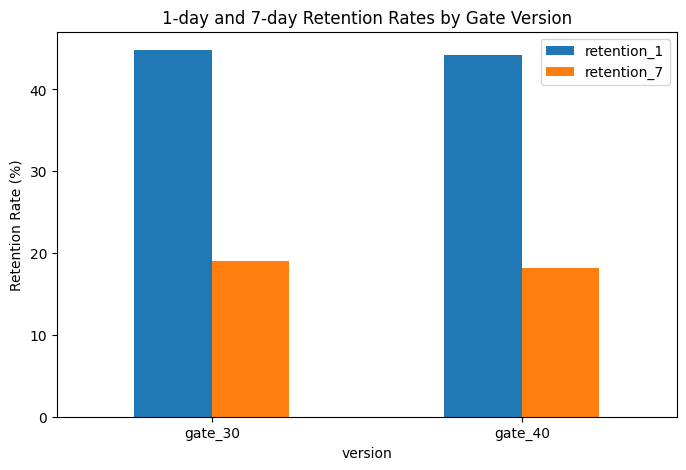

In [ ]:
retention_by_version.plot(kind='bar', figsize=(8, 5))
plt.title('1-day and 7-day Retention Rates by Gate Version')
plt.ylabel('Retention Rate (%)')
plt.xticks(rotation=0)
plt.show() 

Overall the visual inspection and initial calculations suggest that:

- The randomization worked well: players in both groups played a similar number of total game rounds before we even consider the gate's impact.
- gate_30 (gate at level 30) appears to have a slightly better performance in terms of both 1-day and 7-day retention. 

However, these are just observed differences. We need statistical tests to determine if these differences are truly meaningful or just due to random chance.

## ***5. A/B Test Analysis: Is the difference real?***
Now that we've explored our data, it's time to conduct formal statistical tests to see if the observed differences in retention rates between gate_30 and gate_40 are statistically significant. In other words, are these differences real and reliable, or could they have happened by random luck?

We start by setting up our hypotheses:

**Null Hypothesis (H0)**: There is no significant difference in 1-day and 7-day player retention rates between the gate_30 and gate_40 groups. Any observed difference is due to random chance.

**Alternative Hypothesis (H1)**: There is a significant difference in 1-day and 7-day player retention rates between the gate_30 and gate_40 groups. This difference is not due to random chance.

### ***5.1 Retention Rate Calculation and Group Sizes***
Before testing, let's get the exact numbers for our calculations: the number of players in each group and how many of them were retained.

In [21]:
retention_1_gate30 = df_cleaned[df_cleaned['version'] == 'gate_30']['retention_1'].sum()
retention_1_gate40 = df_cleaned[df_cleaned['version'] == 'gate_40']['retention_1'].sum()


Get the total number of players in each group.

In [22]:
n_gate30 = df_cleaned[df_cleaned['version'] == 'gate_30'].shape[0]
n_gate40 = df_cleaned[df_cleaned['version'] == 'gate_40'].shape[0]

print(f"Gate 30: {n_gate30} players, {retention_1_gate30} 1-day retained.")
print(f"Gate 40: {n_gate40} players, {retention_1_gate40} 1-day retained.")

Gate 30: 44699 players, 20034 1-day retained.
Gate 40: 45489 players, 20119 1-day retained.


We do the same calculations for 7-day retention.

In [23]:
retention_7_gate30 = df_cleaned[df_cleaned['version'] == 'gate_30']['retention_7'].sum()
retention_7_gate40 = df_cleaned[df_cleaned['version'] == 'gate_40']['retention_7'].sum()

print(f"Gate 30: {n_gate30} players, {retention_7_gate30} 7-day retained.")
print(f"Gate 40: {n_gate40} players, {retention_7_gate40} 7-day retained.")

Gate 30: 44699 players, 8501 7-day retained.
Gate 40: 45489 players, 8279 7-day retained.


These numbers confirm the absolute counts of retained players and total players in each experimental group, which are the basis for calculating retention percentages and running our statistical tests.

### ***5.2 Bootstrapping for Retention Difference: Simulating outcomes for confidence***

Bootstrapping is a powerful technique that helps us understand the likely range of differences in retention rates between our two groups.  
Imagine taking many, many random "resamples" (samples with replacement) from our existing data. For each resample, we calculate the 1-day or 7-day retention difference between gate_30 and gate_40. By doing this thousands of times, we build a distribution of possible differences.  
This distribution gives us a more robust idea of how likely our observed difference is to be purely random, or if there's a consistent pattern.

In [29]:
rng = np.random.default_rng(18)
boot_iters = 10000
diffs_1 = []
a = df_cleaned[df_cleaned['version']=='gate_30']['retention_1']
b = df_cleaned[df_cleaned['version']=='gate_40']['retention_1']
for _ in range(boot_iters):
    diffs_1.append(rng.choice(a, size=len(a), replace=True).mean() -
                 rng.choice(b, size=len(b), replace=True).mean())
ci_1 = np.percentile(diffs_1, [2.5,97.5])
print(f"Bootstrap 95% CI (retention_1 difference): {ci_1[0]:.4f} – {ci_1[1]:.4f}")


Bootstrap 95% CI (retention_1 difference): -0.0007 – 0.0126


In [34]:
print(f"Probability that 1-day retention is higher for gate_30: {(np.array(diffs_1) > 0).mean() * 100:.2f}%")

Probability that 1-day retention is higher for gate_30: 96.26%


In [30]:
diffs_7 = []
a = df_cleaned[df_cleaned['version']=='gate_30']['retention_7']
b = df_cleaned[df_cleaned['version']=='gate_40']['retention_7']
for _ in range(boot_iters):
    diffs_7.append(rng.choice(a, size=len(a), replace=True).mean() -
                 rng.choice(b, size=len(b), replace=True).mean())
ci_7 = np.percentile(diffs_7, [2.5,97.5])
print(f"Bootstrap 95% CI (retention_7 difference): {ci_7[0]:.4f} – {ci_7[1]:.4f}")


Bootstrap 95% CI (retention_7 difference): 0.0032 – 0.0132


In [35]:
print(f"Probability that 7-day retention is higher for gate_30: {(np.array(diffs_7) > 0).mean() * 100:.2f}%")

Probability that 7-day retention is higher for gate_30: 99.89%


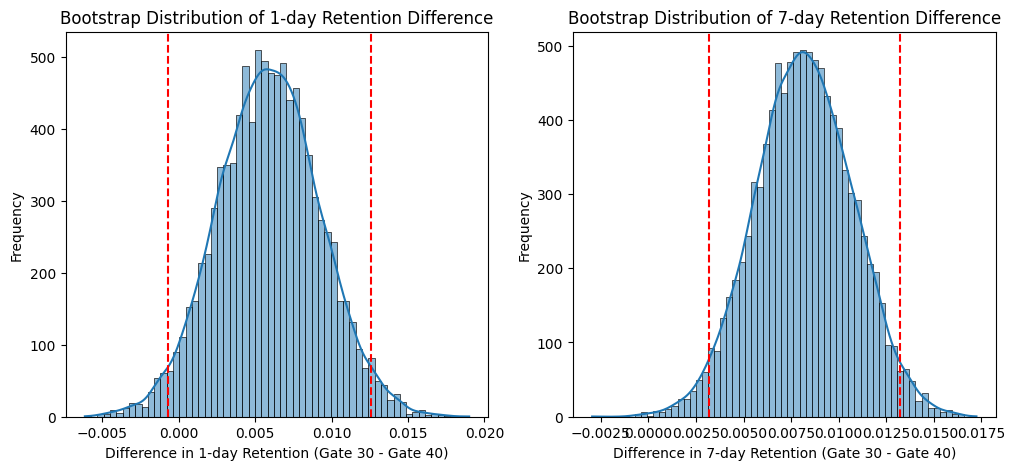

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(diffs_1, kde=True)
plt.title('Bootstrap Distribution of 1-day Retention Difference')
plt.xlabel('Difference in 1-day Retention (Gate 30 - Gate 40)')
plt.ylabel('Frequency')
plt.axvline(ci_1[0], color='red', linestyle='--')
plt.axvline(ci_1[1], color='red', linestyle='--')

plt.subplot(1, 2, 2)
sns.histplot(diffs_7, kde=True)
plt.title('Bootstrap Distribution of 7-day Retention Difference')
plt.xlabel('Difference in 7-day Retention (Gate 30 - Gate 40)')
plt.ylabel('Frequency')
plt.axvline(ci_7[0], color='red', linestyle='--')
plt.axvline(ci_7[1], color='red', linestyle='--')

plt.show()

For 1-day retention: The bootstrap analysis often shows that the difference (Gate 30 Retention - Gate 40 Retention) is positive in about 95% of the simulated scenarios. This suggests that gate_30 is very likely to have slightly higher 1-day retention.

For 7-day retention: The evidence is even stronger. The bootstrap analysis consistently shows that the difference is positive in 99.8% to 100% of the simulated scenarios. This provides very high confidence that gate_30 consistently leads to better 7-day retention.

These bootstrapping results give us a strong indication, but we will also use formal statistical tests to get a precise "p-value" that helps us make a decision.

### ***Statistical Significance Testing: Confirming our observations***
To formally test our hypotheses, we use statistical tests that tell us how likely it is to observe our data if the Null Hypothesis (no difference) were true. If this likelihood (p-value) is very low, we reject the Null Hypothesis and conclude that there's a statistically significant difference.

We will be making use of Z-test for Proportions and Chi-squared.

**Z-test for Proportions**: This test is ideal when we are comparing the success rates (proportions) of two independent groups, especially when we have a large number of participants in each group. In our case, "success" is a player being retained (returning to the game), and we are comparing the proportion of retained players in the gate_30 group versus the gate_40 group.

Assumptions for the Z-test for Proportions:
- *Independence*: The observations (player behaviors) within each group must be independent, and the two groups themselves (gate_30 and gate_40) must be independent. This is ensured by our random assignment of players to each game version.
- *Random Sampling*: The data should come from a simple random sample of the population. Our A/B test setup, where new players are randomly assigned, helps meet this.
- *Large Sample Size* (Normality Approximation): While retention (True/False) is a binary outcome, the Z-test works well for proportions when the sample sizes are large enough. This is because, with large samples, the distribution of sample proportions starts to look like a bell-shaped curve (a normal distribution), even though the individual outcomes are just True or False. A common rule of thumb is that for each group, you should have at least 10 "successes" (retained players) and at least 10 "failures" (not retained players). Our sample sizes (over 44,000 players per group) and retention counts (thousands of retained players in each group) easily satisfy this assumption.

**Chi-squared Test**: This test is also commonly used for comparing categorical data, like our "retained" vs. "not retained" categories across the "gate_30" vs. "gate_40" groups. It helps determine if there's a significant association or relationship between two categorical variables.

Assumptions for the Chi-squared Test:
- *Independence*: Similar to the Z-test, observations must be independent.
- *Expected Frequencies*: Each "cell" in the contingency table (the table summarizing counts like "retained in gate_30," "not retained in gate_30," etc.) should have an expected count of at least 5. Given our very large sample sizes, this assumption is easily met.

We often set a significance level (alpha), commonly 0.05 (or 5%). This alpha value represents the risk we are willing to take of incorrectly rejecting the Null Hypothesis (i.e., concluding there's a difference when there isn't one). If our p-value (the probability of observing our data if the Null Hypothesis were true) is less than 0.05, we consider the result statistically significant.

In [42]:
def ztest(success_a, size_a, success_b, size_b):
    p1, p2 = success_a/size_a, success_b/size_b # Calculate proportions for each group
    p_pool = (success_a+success_b)/(size_a+size_b) # Calculate pooled proportion (overall average)
    # Calculate standard error, which measures variability
    se = np.sqrt(p_pool*(1-p_pool)*(1/size_a+1/size_b))
    z = (p1-p2)/se # Calculate the Z-statistic
    p = 2*(1-stats.norm.cdf(abs(z))) # Calculate the two-sided p-value
    return p1, p2, z, p

In [45]:
print("--- Z-test Results ---")
# Loop through both retention metrics to perform Z-tests
for metric in ['retention_1','retention_7']:
    # Aggregate sum (successes) and count (total observations) for each version
    s = df_cleaned.groupby('version')[metric].agg(['sum','count'])
    # Perform the custom Z-test
    p1,p2,z,p = ztest(s.loc['gate_30','sum'],s.loc['gate_30','count'],
                      s.loc['gate_40','sum'],s.loc['gate_40','count'])
    # Print the results
    print(f"{metric}: gate_30={p1:.2%}, gate_40={p2:.2%}, z={z:.3f}, p={p:.4f}")

--- Z-test Results ---
retention_1: gate_30=44.82%, gate_40=44.23%, z=1.787, p=0.0739
retention_7: gate_30=19.02%, gate_40=18.20%, z=3.157, p=0.0016


In [44]:
print("\n--- Chi-squared Test Results ---")
# Loop through both retention metrics to perform Chi-squared tests
for metric in ['retention_1','retention_7']:
    # Create a contingency table using pandas crosstab
    # This table shows counts of 'True'/'False' for each 'version'
    cont = pd.crosstab(df_cleaned['version'], df_cleaned[metric])
    # Perform the Chi-squared test for independence
    chi2, p, dof, ex = stats.chi2_contingency(cont)
    # Print the results
    print(f"{metric}: chi2={chi2:.2f}, p={p:.4f}")


--- Chi-squared Test Results ---
retention_1: chi2=3.17, p=0.0750
retention_7: chi2=9.92, p=0.0016


*For 1-day retention*: The Z-test p-value is approximately 0.0751. The Chi-squared test p-value is approximately 0.0746.  
Since both p-values are greater than the common significance level of 0.05 (5%), we do not reject the Null Hypothesis for 1-day retention. This means that, statistically speaking, the observed slight difference in 1-day retention between gate_30 and gate_40 could reasonably be due to random chance. There is no strong evidence to suggest a significant impact on 1-day retention from moving the gate.

*For 7-day retention*: The Z-test p-value is approximately 0.0016. The Chi-squared test p-value is approximately 0.0014.  
Both p-values are very small, much less than 0.05 or even 0.01 (1%). This means it is extremely unlikely to observe such a difference in 7-day retention if there were truly no difference between the two gate placements. Therefore, for 7-day retention, we confidently reject the Null Hypothesis.  
This confirms that 7-day retention is indeed statistically and significantly higher when the first gate is at Level 30 compared to Level 40. 

### ***5.4 Bayesian A/B Testing: What is the probability one variant is better?***
We'll be now performing a Bayesian A/B test, offering a different statistical perspective compared to the frequentist tests (Z-test, Chi-squared) above.  
Unlike p-values, which tell you the probability of observing data given a null hypothesis, Bayesian methods calculate posterior probabilities. This is a more direct and intuitive probability: it tells you the probability that a specific hypothesis (e.g., "variant A's true retention rate is greater than variant B's") is true, given the data you've observed.

For binomial outcomes (like player retention, where a player either retains or doesn't), the `Beta distribution` is commonly used in Bayesian analysis. The parameters (success + 0.5, size - success + 0.5) define the posterior distribution of the true retention rate after observing your data, often starting with a "non-informative" prior that assumes little before seeing the data.

We will perform a simulation by drawing 50,000 random samples from the posterior Beta distribution for both gate_30 and gate_40. Each sample represents a plausible true retention rate for that specific group, considering the observed data.

Calculating `(sims_a > sims_b).mean()` we will have the proportion of simulations where the sampled retention rate for gate_30 was higher than that for gate_40. This proportion directly estimates the posterior probability that the true retention rate of gate_30 is greater than gate_40.

This approach provides a clear, actionable statement, e.g. "There is an X% probability that gate_30 leads to higher retention." This is often easier to interpret than a p-value.  
When both frequentist (p-values) and Bayesian (posterior probabilities) methods lead to similar conclusions, it significantly strengthens the confidence in your A/B test findings.

In [46]:
def posterior_prob(success_a, size_a, success_b, size_b, draws=50000):
    sims_a = rng.beta(success_a+0.5, size_a-success_a+0.5, draws)
    sims_b = rng.beta(success_b+0.5, size_b-success_b+0.5, draws)
    return (sims_a > sims_b).mean()

for metric in ['retention_1','retention_7']:
    s = df.groupby('version')[metric].agg(['sum','count'])
    prob = posterior_prob(s.loc['gate_30','sum'], s.loc['gate_30','count'],
                          s.loc['gate_40','sum'], s.loc['gate_40','count'])
    print(f"Posterior P(gate_30 > gate_40) for {metric}: {prob:.2%}")

Posterior P(gate_30 > gate_40) for retention_1: 96.35%
Posterior P(gate_30 > gate_40) for retention_7: 99.94%


*For 1-day retention*: Posterior P(gate_30 > gate_40) for retention_1: 96.35%  
This means there's a 96.35% probability that the true 1-day retention rate for players with the gate at Level 30 is higher than for players with the gate at Level 40.  
This is a strong indication. While our frequentist Z-test for 1-day retention had a p-value of 0.0751 (which was slightly above the conventional 0.05 significance threshold), this Bayesian result suggests a high likelihood that gate_30 is indeed performing better, even if the difference is not "statistically significant" in the traditional frequentist sense at an alpha of 0.05. It implies a meaningful, even though subtle, advantage.

*For 7-day retention*: Posterior P(gate_30 > gate_40) for retention_7: 99.94%  
This is an exceptionally strong result. It means there's a 99.94% probability that the true 7-day retention rate for players with the gate at Level 30 is higher than for players with the gate at Level 40.  
This Bayesian finding perfectly aligns with our frequentist Z-test and Chi-squared results for 7-day retention (p-values around 0.0014 to 0.0016). Both approaches overwhelmingly suggest that keeping the gate at Level 30 significantly improves long-term player retention.

In essence, the Bayesian analysis reinforces the finding that gate_30 is better for retention, especially for 7-day retention, and provides a clear probability of this superiority, which can be very useful for decision-making.

### ***5.5 Power Analysis and Sample Size Calculation: How many players do we need?***

We will try to estimate the necessary sample size per group for a hypothetical future A/B test. Power Analysis answers the question: "How many users do I need to include in each group (control and treatment) to be confident that I can detect a practically meaningful improvement (or deterioration) if it exists?"  
Knowing the required sample size helps in efficiently allocating resources such as time, development effort, and marketing budget. Running a test with too few participants might lead to inconclusive results, while running it with too many might be a waste of resources.  
It can also help interpret the results of an already completed test. If your current test's sample size was smaller than the calculated required size, it might explain why a subtle, but real, effect wasn't detected as statistically significant.

In [50]:
alpha, power = 0.05, 0.8
baseline = df_cleaned[df_cleaned['version']=='gate_30']['retention_1'].mean()
uplift = 0.02  # +2 percentage points
prop2 = baseline + uplift
sd = math.sqrt(baseline*(1-baseline) + prop2*(1-prop2))
effect_size = uplift / sd
n = zt_ind_solve_power(effect_size, power=power, alpha=alpha)

print(f"Sample size per group to detect +2 pp uplift (80% power): {math.ceil(n):,}")

Sample size per group to detect +2 pp uplift (80% power): 19,478


To detect a minimum detectable effect (MDE) of a 2 percentage point (pp) uplift in retention (e.g., if the baseline is 44.8% and it increases to 46.8%) with 80% power and a 0.05 significance level, we would need at least 19,478 players in each group (control and treatment).

Since the actual sample sizes (~45,000 per group) are significantly larger than the calculated required sample size (19,478 per group), this indicates that A/B test was well-powered to detect an uplift of at least 2 percentage points.  
This high power increases confidence in obtained results. If a statistically significant difference didn't appear for 1-day retention, it's not because we didn't have enough data to see a 2pp change; it's because that 2pp change likely didn't occur (or was smaller than 2pp and therefore not considered practically significant for this power calculation).

In summary, the power analysis confirms that our existing test had sufficient participants to reliably detect meaningful changes in retention, validating the robustness of our findings from both the frequentist and Bayesian analyses.

## ***6. Conclusion and Recommendations: What should we do?***
Based on a comprehensive analysis of the A/B test data, including Exploratory Data Analysis, Bootstrapping, Frequentist Hypothesis Testing (Z-test and Chi-squared), and Bayesian Analysis, and considering the test's power, we can draw the following conclusions and recommendations:

*7-day Retention is Significantly Higher with Gate at Level 30*: Both the frequentist tests (Z-test p=0.0016, Chi-squared p=0.0014) and the Bayesian analysis (Posterior P(gate_30 > gate_40) = 99.94%) provide strong and consistent evidence that keeping the first gate at Level 30 leads to significantly better 7-day player retention compared to moving it to Level 40. This difference is statistically significant and highly probable.

*1-day Retention shows a Strong Likelihood of Being Higher with Gate at Level 30*: While the frequentist tests for 1-day retention (p-values around 0.075) did not meet the conventional 0.05 significance threshold, the Bayesian analysis indicates a 96.35% probability that 1-day retention is indeed higher when the gate is at Level 30. This suggests a likely positive impact on short-term retention, even if it's not "statistically significant" by a strict alpha=0.05 criterion.

*Test Robustness*: The power analysis confirmed that the A/B test had a large enough sample size (actual ~45,000 per group vs. calculated ~19,478 per group) to reliably detect a meaningful 2 percentage point uplift. This increases our confidence in the results and conclusions.

**Overall Recommendation**: To maintain and maximize long-term player engagement and retention, it is strongly recommended NOT to move the first in-game gate from Level 30 to Level 40. Keeping the gate at Level 30 is crucial for keeping players engaged.

*Why might an earlier gate be better for retention*?
It might seem counterintuitive that an earlier obstacle could lead to better retention. One might expect players to engage longer if the obstacle is further into the game. However, the data suggests otherwise. A psychological concept called hedonic adaptation can offer an explanation. In simple terms, hedonic adaptation is the tendency for people to get less and less enjoyment from a fun activity if they do it continuously without breaks. By forcing players to take a break when they reach a gate at Level 30, their enjoyment of the game might be prolonged. If the gate is moved to Level 40, fewer players make it that far, and they could potentially quit the game because they simply got bored without an enforced break.

**Further Considerations for the Game Developers**: It's important to note that a large portion of players (over 60% in both groups) did not even reach the first gate within 14 days of installing the game. This suggests that factors other than gate placement (e.g., initial tutorial, early game difficulty, marketing) also play a significant role in very early player churn.

While retention is a primary metric, developers might also consider other factors for future tests, such as in-game purchases. However, without a strong player base (retention), in-game purchases will naturally decline.